In [2]:
from python_dict_wrapper import wrap
import sys
sys.path.append('../')

In [5]:
args = wrap({'features': 'airsim_04',
             'ckpt_root': '../pretrained',
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})

from fmri_models import get_feature_model

model, _, _ = get_feature_model(args)

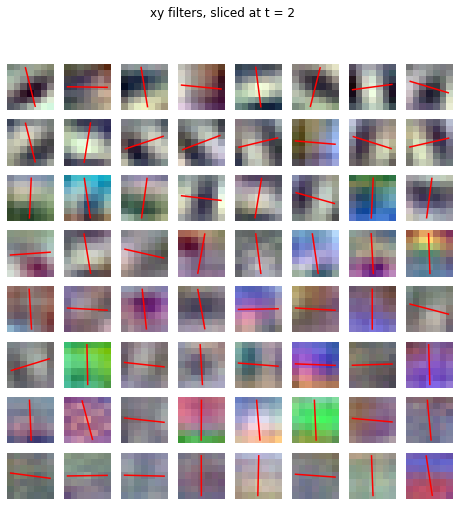

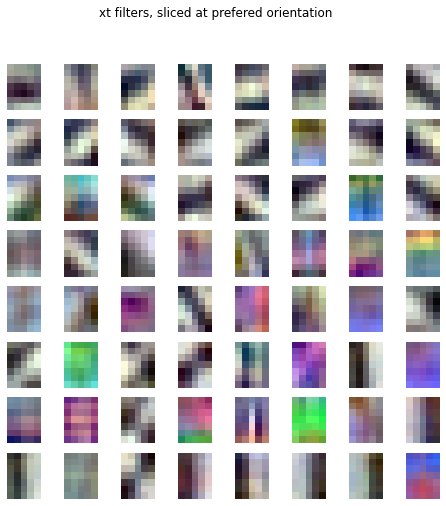

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

def find_dominant_orientation(W):
    Wf = abs(np.fft.fft2(W))
    orient_sel = 1 - Wf[0, 0] / Wf.sum()
    Wf[0, 0] = 0
    Wf = np.fft.fftshift(Wf)
    dt = W.shape[0] // 2
    xi, yi = np.meshgrid(np.arange(-dt, dt+1), np.arange(-dt, dt+1))
    
    # Check whether we should split this horizontally or vertically
    if Wf[xi == 0].sum() > Wf[yi == 0].sum():
        # Use a top-down split        
        xi_ = xi * (xi >= 0)
        yi_ = yi * (xi >= 0)
        x0 = (xi_ * Wf).sum() / ((xi >= 0) * Wf).sum()
        y0 = (yi_ * Wf).sum() / ((xi >= 0) * Wf).sum()
    else:
        xi_ = xi * (yi >= 0)
        yi_ = yi * (yi >= 0)
        x0 = (xi_ * Wf).sum() / ((yi >= 0) * Wf).sum()
        y0 = (yi_ * Wf).sum() / ((yi >= 0) * Wf).sum()
    return np.arctan2(y0, x0), orient_sel

def get_spatial_slice(W, theta):
    dx = W.shape[0] // 2
    dt = W.shape[2] // 2
    xi, yi, zi = np.meshgrid(np.arange(W.shape[0]), 
                             np.arange(W.shape[1]),
                             np.arange(W.shape[2]))
    
    xi_, zi_ = np.meshgrid(np.arange(W.shape[0]), 
                         np.arange(W.shape[2]))
    Ws = []
    for i in range(W.shape[3]):
        interp = scipy.interpolate.LinearNDInterpolator(np.array([xi.ravel(), 
                                                                  yi.ravel(), 
                                                                  zi.ravel()]).T, W[:, :, :, i].ravel())
        probe = np.array([dx + (xi_ - dx) * np.cos(theta),
                 dx + (xi_ - dx) * np.sin(theta),
                 zi_]).T
        Ws.append(interp(probe))
        
    return np.stack(Ws, axis=2)

def plot_static_shot(W):
    assert W.shape[0] == 64
    W = W / abs(W).max(axis=4).max(axis=3).max(axis=2).max(axis=1).reshape(-1, 1, 1, 1, 1) / 2 + .5
    t = W.shape[2] // 2
    
    best_thetas = []
    orient_sels = []
    for i in range(64):
        theta, orient_sel = find_dominant_orientation(W[i, :, t, :, :].transpose(1, 2, 0).sum(2))
        best_thetas.append(theta)
        orient_sels.append(orient_sel)
        
    best_thetas = np.array(best_thetas)
    orient_sels = np.array(orient_sels)
    
    sort_idx = np.argsort(orient_sels)[::-1]
    best_thetas = best_thetas[sort_idx]
    orient_sels = orient_sels[sort_idx]
    W = W[sort_idx, :, :, :, :]
    
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(W[i, :, t, :, :].transpose(1, 2, 0))
        theta = best_thetas[i]
        plt.plot([3 + 3 * np.sin(theta), 3 - 3 * np.sin(theta)], [3 + 3 * np.cos(theta), 3 - 3 * np.cos(theta)], 'r-')
        plt.axis(False)
    plt.suptitle(f'xy filters, sliced at t = {t}')
    plt.show()
        
    dt = W.shape[-1] // 2
    xi, yi = np.meshgrid(np.arange(-dt, dt+1), np.arange(-dt, dt+1))
    
    plt.figure(figsize=(8, 8))
    for i in range(64):
        W_ = W[i, :, :, :, :].transpose((3, 2, 1, 0))
        plt.subplot(8, 8, i + 1)
        theta = best_thetas[i]
        W_ = get_spatial_slice(W_, theta)
        plt.imshow(W_)
        plt.axis(False)
    plt.suptitle('xt filters, sliced at prefered orientation')

#plot_static_shot(model.model.s1.pathway0_stem.conv.weight.detach().cpu().numpy())
#plt.imshow()
#W = model.model.s1.pathway0_stem.conv.weight.detach().cpu().numpy()[2, 0, 2, :, :]
"""
W = np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0]])
W = np.array([[0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 1, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0]]).T
W = np.array([[1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 1]])
#W = np.rot90(W)


plt.imshow(W)
plt.plot(, 'r-')
"""
#plot_static_shot(model.stem[0].weight.detach().cpu().numpy())
plot_static_shot(model.s1.conv1.weight.detach().cpu().numpy())
#plt.suptitle('Filters of I3D network at t = 2, sorted by orientation selectivity')

In [7]:
model

DorsalNet(
  (s1): ShallowNet(
    (conv1): Conv3d(3, 64, kernel_size=[5, 7, 7], stride=[1, 2, 2], padding=[2, 3, 3], bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    (dropout): Dropout3d(p=0, inplace=False)
  )
  (res0): ResBlock(
    (branch1): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=[1, 1, 1], bias=False)
    (branch1_bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (branch2): BottleneckTransform(
      (a): Conv3d(64, 8, kernel_size=[1, 1, 1], stride=[1, 1, 1], padding=[0, 0, 0], bias=False)
      (a_bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a_relu): ReLU(inplace=True)
      (b): Conv3d(8, 8, kernel_size=[1, 3, 3], stride=[1, 1, 1], padding=[0, 1, 1], dilation=[1

In [135]:
args = wrap({'features': 'airsim_02',
             'ckpt_root': '../pretrained',
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})

from fmri_models import get_feature_model

model, _, _ = get_feature_model(args)

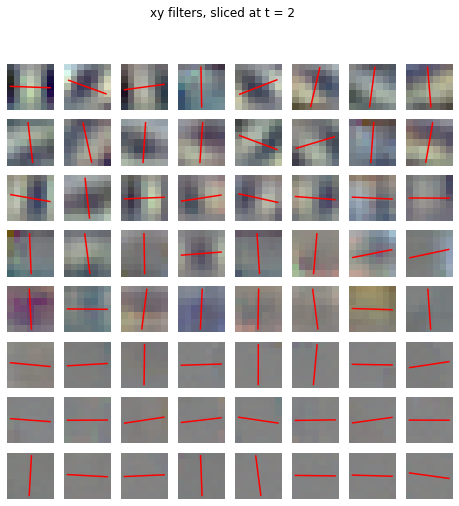

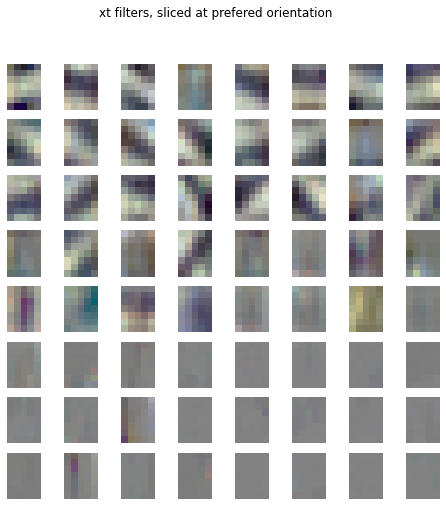

In [136]:
plot_static_shot(model.s1.conv1.weight.detach().cpu().numpy())

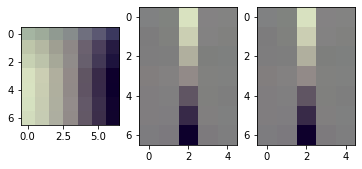

In [122]:
import scipy


W = model.model.s1.pathway0_stem.conv.weight.detach().cpu().numpy()[15, :, :, :, :].transpose((3, 2, 1, 0))
plt.subplot(131)
plt.imshow(W[:, :, 2, :] / abs(W).max() / 2 + .5)
plt.subplot(132)
W_ = get_spatial_slice(W, 0)
plt.imshow(W_ / abs(W_).max() * .5 + .5)
plt.subplot(133)
plt.imshow(W[3, :, :, :] /  abs(W).max() / 2 + .5)
#plt.imshow(W_[])

In [14]:
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

from python_dict_wrapper import wrap

def get_anim(result, norm=False, title=""):
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()
    im = plt.imshow([[1]], cmap='gray')
    
    if title:
        plt.suptitle(title)
    plt.axis('off')
    nt = result.shape[-1]

    rg = None
    if norm:
        rg = [result.min(), result.max()]

    def drawframe(n):
        if n >= nt:
            n = nt - 1
        else:
            im.set_data(result[:, :, :, n])
        if norm:
            im.set_clim(rg)
        return (im)

    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=nt*2, interval=500, blit=False)
    plt.close()
    return anim

for features in ['airsim_04']:
    args = wrap({'features': features,
                 'ckpt_root': '../pretrained'})

    from fmri_models import get_feature_model

    model, _, _ = get_feature_model(args)

    if features == 'V1Net':
        w = model.s1.conv1.weight.cpu().detach().numpy()
    else:
        w = model.conv1.weight.cpu().detach().numpy()
    #w = w / abs(w).max()
    w = w / abs(w).max(axis=4).max(axis=3).max(axis=2).max(axis=1).reshape(-1, 1, 1, 1, 1)
    ani = get_anim(.5 + .5*w.reshape((8, 8, 3, 5, 7, 7)).transpose((0, 4, 1, 5, 2, 3)).reshape((7*8, 7*8, 3, 5)))
        
    # writer = FFMpegWriter(fps=10)
    ani.save(f"figures/filters_{features}.gif", writer='imagemagick', fps=12, bitrate=10000)  

In [15]:
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

from pathlib import Path

import torch

def get_anim(result, norm=False, title=""):
    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()
    im = plt.imshow([[1]], cmap='gray')
    
    if title:
        plt.suptitle(title)
    plt.axis('off')
    nt = result.shape[2]

    rg = None
    if norm:
        rg = [result.min(), result.max()]

    def drawframe(n):
        if n >= nt:
            n = nt - 1
        else:
            im.set_data(result[:, :, :, n])
        if norm:
            im.set_clim(rg)
        return (im)

    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=nt*2, interval=500, blit=False)
    plt.close()
    return anim

checkpoints = Path('../models/dorsalnet_slower/').glob('*.pt')

ws = []
for i, path in enumerate(sorted(list(checkpoints))[::10]):
    data = torch.load(str(path))
    w = data['subnet.s1.conv1.weight'].cpu().detach().numpy()
    w = w / abs(w).max()
    ani = get_anim(.5 + .5*w.reshape((4, 4, 3, 5, 7, 7)).transpose((0, 4, 1, 5, 2, 3)).reshape((28, 28, 3, 5)), title=f'Step {i}')
        
    writer = FFMpegWriter(fps=10)
    ani.save(f"figures/filters_dorsalnet_{i}.gif", writer=writer)

    ws.append(w.ravel())

In [18]:
import numpy as np

np.testing.assert_allclose(ws[0], ws[-1])

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 11759 / 11760 (100%)
Max absolute difference: 0.08925858
Max relative difference: 3036.3225
 x: array([ 0.051969, -0.028676, -0.064085, ...,  0.097489, -0.052117,
        0.026089], dtype=float32)
 y: array([ 0.063339, -0.005472, -0.032252, ...,  0.107188, -0.049879,
        0.032908], dtype=float32)